# Introduction

This notebook does some exploratory data analysis on the [Safety](https://www.aiforsea.com/safety) data and removes invalid trips.

# Libraries

In [3]:
import pyspark.sql.functions as f
import matplotlib.pyplot as plt

# Data

Load the features and label dataframe:

In [6]:
label_df = spark.read.parquet('dbfs:/msh/grab/data/label.parquet')
feature_df = spark.read.parquet('dbfs:/msh/grab/data/features.parquet')

# Labels

## General

In [9]:
display(label_df.describe())

summary,bookingID,label
count,20018,20018
mean,8.162398898404436E11,0.24982515735837746
stddev,4.945544420934139E11,0.4329225228356394
min,0,0
max,996432412828,1


## Distribution

In [11]:
frac_unsafe = label_df.select(f.mean('label').alias('frac_1')).collect()[0]['frac_1']
print(f'Fraction of trips labeled unsafe: {frac_unsafe:.2f}')

Fraction of trips labeled unsafe: 0.25

## Sanity Checks

Check labels are either 0 or 1:

In [14]:
display(label_df.select('label').distinct())

label
1
0


Check that each `bookingID` have one label only:

In [16]:
multilabel_bookings = label_df\
  .groupBy('bookingID')\
  .count()\
  .filter(f.col('count') != 1)\
  .orderBy('count')

multilabel_bookings.count()

Out[7]: 18

# Features

## General

In [19]:
display(feature_df.describe())

summary,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,16135561,16135561,16135561,16135561,16135561,16135561,16135561,16135561,16135561,16135561,16135561
mean,8.184818566602681E11,11.610351609225747,168.96835558681013,0.06914528676263748,4.468976226144786,0.8942973527874611,-0.001710847042108558,2.8007331766258074E-4,-2.5696881294001717E-4,3803.4841827315454,9.006543481018097
stddev,4.952475771950221E11,86.91672000895586,107.29660958426084,1.4241614808750849,8.13066407580465,3.251549021396225,0.14456192719444005,0.34006299869145784,0.1480824475333444,1436686.492877957,8.106414946792125
min,0,0.75,0.0,-78.419685,-72.99411926269532,-78.44842,-48.45575,-74.88861,-53.55445,0.0,-2.0
max,996432412828,6070.101,359.9994812011719,66.87345581054689,75.055885,78.055756,39.83975,80.314964,66.30078,1.495796757E9,148.01863


Since the value range in for acceleration in the x, y and z axis is way beyond 9.81 m/s2, we will assume that the phone can be in any orientation during a trip.

### Number of Bookings

In [22]:
feature_df.select('bookingID').distinct().count()

Out[9]: 20000

### Trip Length

Compute the length of each trip:

In [25]:
trip_length_df = feature_df\
  .groupBy('bookingID')\
  .agg(f.max('second').alias('trip_length'))\
  .orderBy('trip_length')

display(trip_length_df)

bookingID,trip_length
1494648619032,119.0
180388626478,119.0
386547056705,119.0
618475290784,119.0
541165879344,119.0
309237645388,119.0
575525617768,119.0
1511828488332,119.0
1185410973839,119.0
309237645328,119.0


View distribution of trip length:

In [27]:
trip_length_df.approxQuantile('trip_length', [0., 0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99, 1.], 0.)

Out[11]: 
[119.0,
 355.0,
 554.0,
 854.0,
 1221.0,
 1319.0,
 1559.0,
 1739.0,
 2252.0,
 1495796757.0]

Assume valid trips are trips longer than 20 minutes and less than [8 hours](https://www.news.com.au/lifestyle/real-life/wtf/the-longest-ride-in-uber-history/news-story/101dc11c0db4742ec377fb4dec4ad424):

In [29]:
min_length = 20 * 60
max_length = 8 * 60 * 60

min_length, max_length

Out[12]: (1200, 28800)

In [30]:
valid_trips_df = trip_length_df\
  .filter((f.col('trip_length') >= min_length) & (f.col('trip_length') <= max_length))

valid_trips_df.count()

Out[13]: 5193

Update `feature_df` to only have valid trips:

In [32]:
valid_trips = valid_trips_df.select('bookingID').toPandas()['bookingID'].values.tolist()
feature_df = feature_df.filter(f.col('bookingID').isin(valid_trips))
feature_df.select('bookingID').distinct().count(), feature_df.count()

Out[14]: (5193, 6961555)

View the new trip length distribution:

In [34]:
display(valid_trips_df.describe())

summary,bookingID,trip_length
count,5193,5193
mean,8.237570281945043E11,1555.4904679376084
stddev,4.974116896064372E11,351.9305221307132
min,0,1200.0
max,996432412828,8235.0


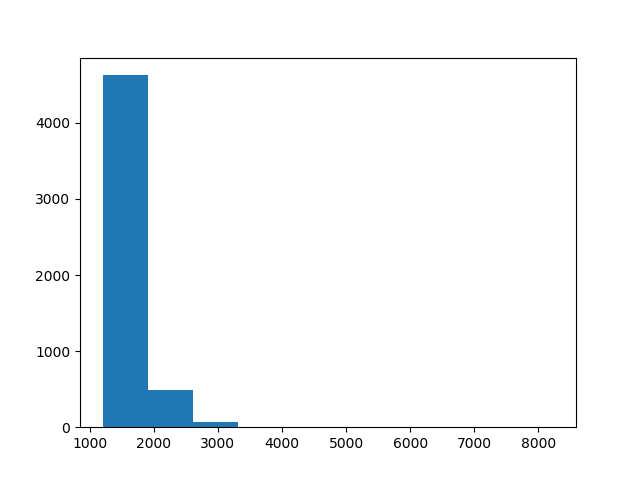

In [35]:
x = valid_trips_df.select('trip_length').toPandas()['trip_length'].values
fig, ax = plt.subplots(1, 1)
ax.hist(x)
display(fig)

## Accuracy

View distribution of accuracy:

In [38]:
feature_df.approxQuantile('Accuracy', [0., 0.1, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 1.], 0)

Out[17]: [0.75, 3.0, 3.9, 4.215, 8.0, 12.0, 16.0, 65.0, 5646.0]

Assume accuracy beyond 100 meters is not acceptable:

In [40]:
feature_df = feature_df\
  .filter(f.col('Accuracy') <= 100.0)

feature_df.count()

Out[18]: 6917686

### Speed

View distribution of speed:

In [43]:
feature_df.approxQuantile('Speed', [0., 0.1, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 1.], 0)

Out[19]: 
[-2.0,
 0.0,
 1.55,
 9.193446159362793,
 17.430421829223633,
 22.239999771118164,
 24.192793,
 27.11,
 148.01863]

Clearly, speed cannot be negative. Let's assume that speeds above 200 km/h are unacceptable:

In [45]:
min_speed = 0
max_speed = 55.56

feature_df = feature_df\
  .filter((f.col('Speed') > min_speed) & (f.col('Speed') <= max_speed))

feature_df.count()

Out[20]: 5737122

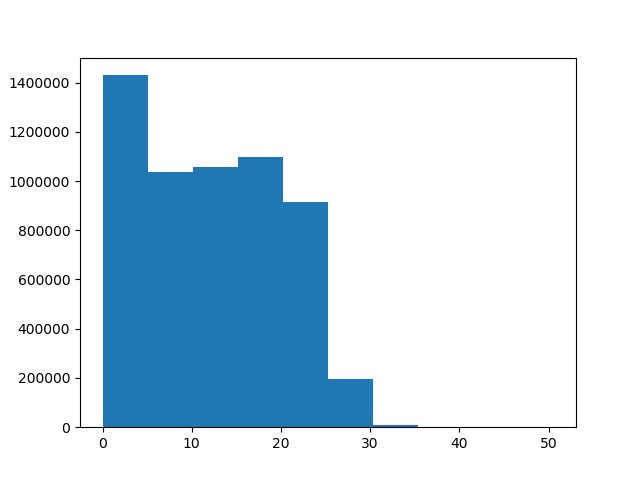

In [46]:
x = feature_df.select('Speed').toPandas()['Speed'].values
fig, ax = plt.subplots(1, 1)
ax.hist(x)
display(fig)

### Multi label trips

Total valid trips:

In [49]:
feature_df.select('bookingID').distinct().count()

Out[22]: 5181

Number of trips with multiple labels:

In [51]:
multilabel_bookings.count()

Out[23]: 18

Drop the trips with the mulitple labels:

In [53]:
feature_df = feature_df\
  .join(multilabel_bookings, ['bookingID'], 'leftanti')

feature_df.select('bookingID')\
  .distinct()\
  .count()

Out[24]: 5171

# Save

Save the details of the valid trips:

In [56]:
feature_df.write.parquet('dbfs:/msh/grab/data/features_valid.parquet')